# DBSCAN: Density-Based Spatial Clustering of Applications with Noise
DBSCAN is a density-based clustering algorithm that groups together points that are closely packed together while filtering out noise points that lie in low-density regions.

> Unlike k-means, DBSCAN can identify clusters of various shapes and sizes, and it does not require the number of clusters to be specified in advance.

DBSCAN determines the density of an area based on two parameters:
- **Epsilon ($\epsilon$)**: The radius of the neighborhood around a data point.
- **Minimum Points ($\text{minPts}$)**: The minimum number of data points required to form a dense region.

Based on these two parameters, the algorithm differentiates between three types of data points:

1. **Core Points**: A data point is a core point if at least $\text{minPts}$ points are within a distance of $\epsilon$ from it.
2. **Border Points**: A data point is a border point if it is within a distance of $\epsilon$ from a core point, but it is not a core point itself.
3. **Noise Points**: A data point is a noise point if it is neither a core point nor a border point.

<img src="media/dbscan.png" alt="DBSCAN" width="500">

In addition, we define reachability relations between points:
- A point $p$ is **directly reachable** from a point $q$ if $p$ is within a distance of $\epsilon$ from $q$ and $q$ is a core point.
- A point $p$ is **reachable** from a point $q$ if there is a path $p_1, ..., p_n$ such that $p_1 = q$ and $p_n = p$ and $p_{i+1}$ is directly reachable from $p_i$.

## DBSCAN Algorithm
The DBSCAN algorithm works as follows:
1. Randomly choose a data point $p$.
2. Retrieve all points directly reachable from $p$.
3. If $p$ is a core point, a cluster is formed.
4. If $p$ is a border point, no points are reachable from $p$, and DBSCAN visits the next point of the database.
5. Repeat steps 1-4 until all points have been processed.

DBSCAN algorithm is deterministic – always generating the same clusters – when presented with the same data points in the same order. However, the results may vary when the data points are presented in a different order.

## DBSCAN In Scikit-Learn
Scikit-Learn provides an implementation of the DBSCAN algorithm in the class `sklean.cluster.DBSCAN.` Important hyperparameters of this class include:

- `eps:` The $\epsilon$ parameter of the algorithm (the radius of a neighborhood around a data point). The default value of this parameter is 0.5.
- `min_samples:` The `MinPts` parameter of the algorithm (the number of points in a neighborhood for a point to be considered as a core point). The default value of this parameter is 5.
- `metric:` The distance metric to use for computing distances between data points (defaults to `'euclidean'`).
- `algorithm:` The algorithm (data structure) used to find nearest neighbors of a given sample. The options are 'auto' (the default), 'ball_tree', 'kd_tree', 'brute'. The option 'auto' means that Scikit-Learn will use the most appropriate algorithm for the given dataset.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import DBSCAN

In [2]:
X, y = make_blobs(n_samples=500, centers=3, cluster_std=0.6, random_state=0)
X = StandardScaler().fit_transform(X)

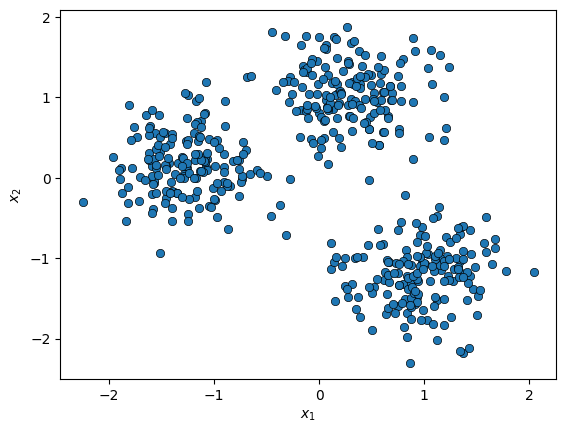

In [9]:
def plot_data(X):
    sns.scatterplot(x=X[:, 0], y=X[:, 1], edgecolor='k', legend=False)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

def plot_clusters(X, dbscan):
    labels = dbscan.labels_
    
    # identify the border points
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[dbscan.core_sample_indices_] = True
    border_samples_mask = ~core_samples_mask & (labels != -1)
   
    # identify the noise points
    noise_samples_mask = (labels == -1)
    noise_points = X[noise_samples_mask]
    
    # assign a different dot size for each type of point
    sizes = np.zeros_like(labels, dtype=int)
    sizes[core_samples_mask] = 100
    sizes[border_samples_mask] = 50
    sizes[noise_samples_mask] = 25
    
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette='tab10', edgecolor='k', 
                    s=sizes, legend=False)
    
    # draw the noise points in black
    sns.scatterplot(x=noise_points[:, 0], y=noise_points[:, 1], color='k', legend=False)
    
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

def print_cluster_stats(dbscan):
    labels = dbscan.labels_

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_points = np.count_nonzero(labels == -1)

    print('Number of clusters:', n_clusters)
    print('Number of noise points:', n_noise_points)

plot_data(X)

In [6]:
dbscan = DBSCAN()
dbscan.fit(X)

DBSCAN()

In [7]:
print_cluster_stats(dbscan)

Number of clusters: 1
Number of noise points: 0


In [8]:
dbscan = DBSCAN(eps=0.3)
dbscan.fit(X)

print_cluster_stats(dbscan)

Number of clusters: 3
Number of noise points: 14


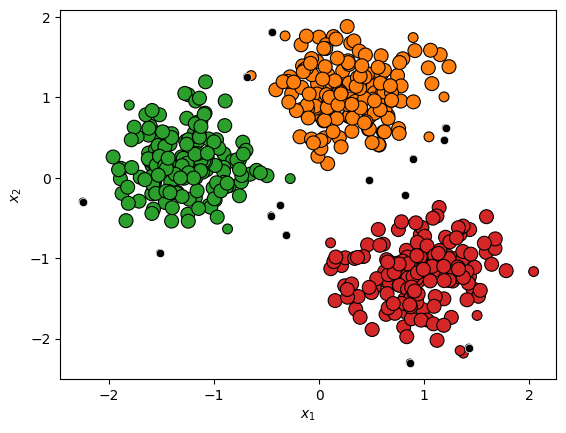

In [10]:
plot_clusters(X, dbscan)

### Choosing Algorithm Parameters for DBSCAN

DBSCAN's effectiveness heavily relies on its parameters, ϵ (epsilon) and MinPts. These parameters are dataset-specific and influence the algorithm's sensitivity to data structure and clustering objectives.

- **MinPts**: Determines tolerance to outliers. Higher MinPts results in smaller, denser clusters and more noise identification. A general guideline is to set MinPts at least to the number of dimensions in the dataset (m) plus one, allowing for an adequate assessment of local neighborhood density.

- **ϵ (epsilon)**: Balances cluster granularity and noise sensitivity. Too small ϵ leads to minimal clustering, while too large ϵ merges distinct clusters. Selecting ϵ typically involves constructing a k-distance graph, plotting distances to the k-th nearest neighbor (k often equals MinPts). The “elbow” in this graph, where distance changes sharply, suggests an optimal ϵ value.

In [11]:
def plot_k_distance_graph(X, k):
    # Compute pairwise distances between the points (using Euclidean distance)
    distances = pairwise_distances(X)
    
    # Sort the distances for each point
    sorted_distances = np.sort(distances, axis=1)
    
    # Get the distance of each point to its k-nearest neighbor
    k_distances = sorted_distances[:, k]
    
    # Sort the k-distances
    sorted_k_distances = np.sort(k_distances)
    
    # Plot the k-distance graph
    plt.plot(sorted_k_distances)
    plt.xlabel('Data Point Index')
    plt.ylabel(f'{k}-Distance')
    plt.grid()

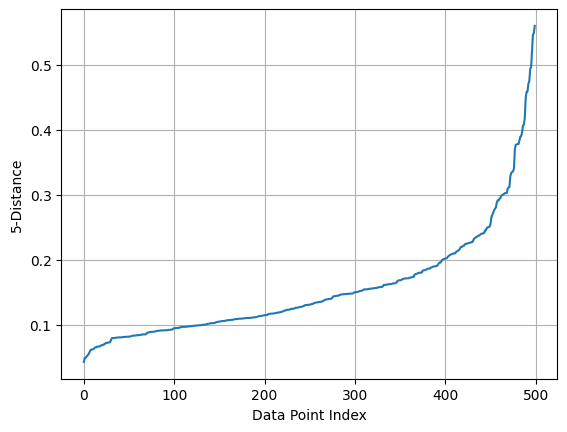

In [12]:
plot_k_distance_graph(X, k=5)

We can see that the elbow point is around a 5-distance of $0.3$, which is the value that we used for ϵ in the second run of DBSCAN.

### Handling Clusters of Arbitrary Shapes
One of the main advantages of DBSCAN over other clustering algorithms, such as k-means or hierarchical clustering, is that it can handle clusters of arbitrary shapes, as long as they have similar densities.

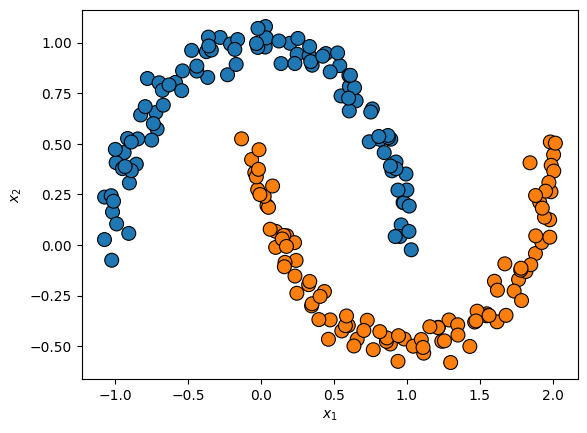

In [13]:
X_moons, y_moons = make_moons(n_samples=200, noise=0.05, random_state=0)

dbscan = DBSCAN(eps=0.3)
dbscan.fit(X_moons)
plot_clusters(X_moons, dbscan)

In [14]:
print_cluster_stats(dbscan)

Number of clusters: 2
Number of noise points: 0


## Summary
Let’s summarize the pros and cons of DBSCAN as compared to other clustering algorithms:

**Pros:**
- Does not require to specify the number of clusters in advance.
- Can find clusters of arbitrary shapes. It can even find a cluster completely surrounded by a different cluster.
- Robust to outliers, since it can differentiate between noise points and points belonging to clusters. This ability allows to use DBSCAN as an ouliter detection method.
- Can be used with any distance function.
- Produces stable clusters, i.e., adding new points usually do not change the existing clusters drastically.

**Cons:**
- The results of the algorithm heavily depend on the choice of the parameters $\epsilon$ and `MinPts.`
- Does not work well with clusters of different densities.
- In high-dimensional data, data points become more sparsely distributed, which can make it challenging for DBSCAN to find dense regions effectively.
- The algorithm is not entirely deterministic: border points that are reachable from two clusters can be part of either, depending on the order the data points are processed.
- Less efficient than centroid-based clustering algorithms like k-means.